In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_lasagne/log/gui'
spiketrains_batch = np.load(os.path.join(path, 'avg_max', 'spiketrains', '0.npz'))['spiketrains']
print("spiketrains_batch is list of tuples: [(layer0_spiketrains, layer0_name), ...]")
print("Shape of layer_spiketrains: (batch_size, feature-maps, width, height, timesteps)")
print("E.g. first layer: {}".format(spiketrains_batch[0][0].shape))
activations_batch = np.load(os.path.join(path, 'avg_max', 'activations', '0.npz'))['activations']
spikerates_avg_measured = np.load(os.path.join(path, 'avg_max', 'debug_vars.npz'))['spikerates02']
spikerates_fir_measured = np.load(os.path.join(path, 'fir_max', 'debug_vars.npz'))['spikerates02']
spikerates_exp_measured = np.load(os.path.join(path, 'exp_max', 'debug_vars.npz'))['spikerates02']
T = spiketrains_batch[0][0].shape[-1]  # Simulation time

spiketrains_batch is list of tuples: [(layer0_spiketrains, layer0_name), ...]
Shape of layer_spiketrains: (batch_size, feature-maps, width, height, timesteps)
E.g. first layer: (1, 32, 149, 149, 200)


In [3]:
# Get spiketrains of first 10 neurons of first row of first feature map
# of first image of layer 02Conv preceeding 03MaxPooling
spiketrains = spiketrains_batch[2][0][0, 0, 0, :10]  # Shape: (10, 200)
spikes = np.greater(spiketrains, 0)
# Get the corresponding target activations
activations = activations_batch[2][0][0, 0, 0, :10]  # Shape: (10,)
target_activations = np.outer(np.ones(T), activations)

In [18]:
true_order = np.argsort(activations)


def get_order_correctness(spikerates, true_order):
    return [100 * np.mean(true_order == np.argsort(r)) for r in spikerates.transpose()]


def plot_order_correctness(spikerates_list, true_order, labels):
    for i, spikerates in enumerate(spikerates_list):
        order_acc = get_order_correctness(spikerates, true_order)
        plt.plot(order_acc, label=labels[i])
    plt.legend(loc='lower right')
    plt.title('Correctness of ordering spike-rates')
    plt.xlabel('t')
    plt.ylabel('accuracy [%]')


def plot_max_correctness(spikerates_list, activations, labels):
    for i, spikerates in enumerate(spikerates_list):
        max_acc = [100 * np.mean(np.argmax(activations) == np.argmax(r)) for r in spikerates.transpose()]
        plt.plot(max_acc, label=labels[i])
    plt.legend(loc='lower right')
    plt.title('Correctness of maximum spike-rate')
    plt.xlabel('t')
    plt.ylabel('accuracy [%]')
    plt.ylim(-1, 101)

In [5]:
# 'avg_max'
spikerates_avg = np.cumsum(spikes, axis=1) / np.arange(1, T + 1)
# Equivalent methods:
# spikerates_avg = np.zeros_like(spiketrains)
# for t in range(T):
#     spikerates_avg[:, t] = spikerates_avg[:, t - 1] + (spikes[:, t] - spikerates_avg[:, t - 1]) / (t + 1)
#     # Or: spikerates_avg[:, t] = (spikerates_avg[:, t - 1] * t + spikes[:, t] ) / (t + 1)

In [6]:
# 'fir_max'
spikerates_fir = np.zeros_like(spiketrains)
for t in range(T):
    spikerates_fir[:, t] = spikerates_fir[:, t - 1] + spikes[:, t] / (t + 1)

In [7]:
# 'exp_max'
spikerates_exp = np.zeros_like(spiketrains)
for t in range(T):
    spikerates_exp[:, t] = spikerates_exp[:, t - 1] + spikes[:, t] / 2. ** (t + 1)

In [8]:
# Running average with sliding window

from collections import deque

spikerates_run = np.zeros_like(spiketrains)
cache = deque()
n = 10  # window size
cum_sum = 0
for t in range(T):
    cache.append(spikes[:, t])
    cum_sum += spikes[:, t]
    if t < n:
        spikerates_run[:, t] = cum_sum / (t + 1)
    else:                           # if window is saturated,
        cum_sum -= cache.popleft()  # subtract oldest value
        spikerates_run[:, t] = cum_sum / n

In [9]:
% matplotlib inline
colors = plt.cm.spectral(np.linspace(0, 0.9, 10))
colors = np.concatenate((colors, colors))

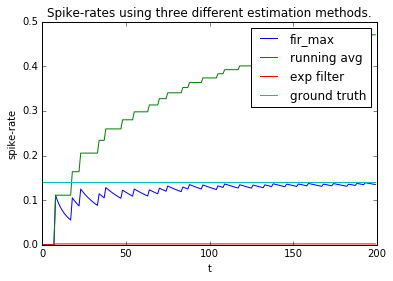

In [10]:
sr = np.stack([spikerates_avg[0], spikerates_fir[0], spikerates_exp[0], np.ones(T) * activations[0]])
plt.plot(sr.transpose())
plt.xlabel('t')
plt.ylabel('spike-rate')
plt.title('Spike-rates using three different estimation methods.')
plt.legend(['fir_max', 'running avg', 'exp filter', 'ground truth']);

In [8]:
def plot_spiketrains(spiketimes, label):
    plt.gca().set_prop_cycle(plt.cycler('color', colors))
    plt.xlabel('t')
    plt.ylabel('neuron index')
    plt.title('Spike-trains of layer {}'.format(label))
    for (neuron, spiketrain) in enumerate(spiketimes):
        spikelist = [j for j in spiketrain if j != 0]
        y = np.ones_like(spikelist) * neuron
        plt.plot(spikelist, y, '.')

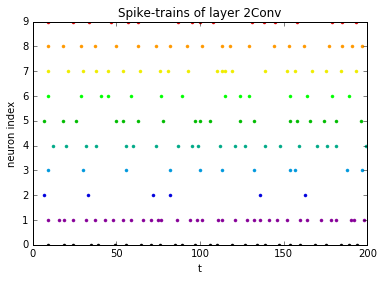

In [9]:
plot_spiketrains(spiketrains, '2Conv')

In [4]:
def plot_spikerates(spikerates, spikerates_measured, target_activations):
    f, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    f.set_figwidth(15)
    f.set_figheight(5)
    f.suptitle('Average spike-rates of 10 neurons, with ground-truth')
    ax[0].set_xlabel('t')
    ax[1].set_xlabel('t')
    ax[0].set_ylabel('spike-rate')
    ax[0].set_prop_cycle(plt.cycler('color', plt.cm.spectral(np.linspace(0, 0.9, 10))))
    ax[1].set_prop_cycle(plt.cycler('color', plt.cm.spectral(np.linspace(0, 0.9, 10))))
    ax[0].plot(np.concatenate((spikerates_measured, target_activations), axis=1))
    ax[1].plot(np.concatenate((spikerates.transpose(), target_activations), axis=1))
    ax[0].set_title('Calculated from spikes recorded during simulation')
    ax[1].set_title('Measured directly from calculation in simulator')

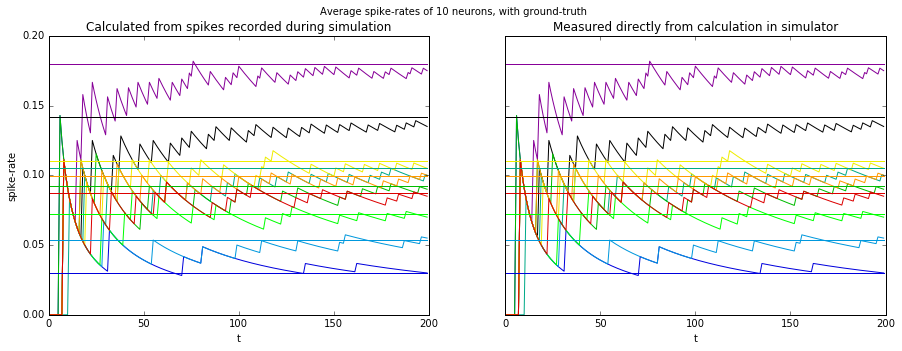

In [14]:
plot_spikerates(spikerates_avg, spikerates_avg_measured, target_activations)

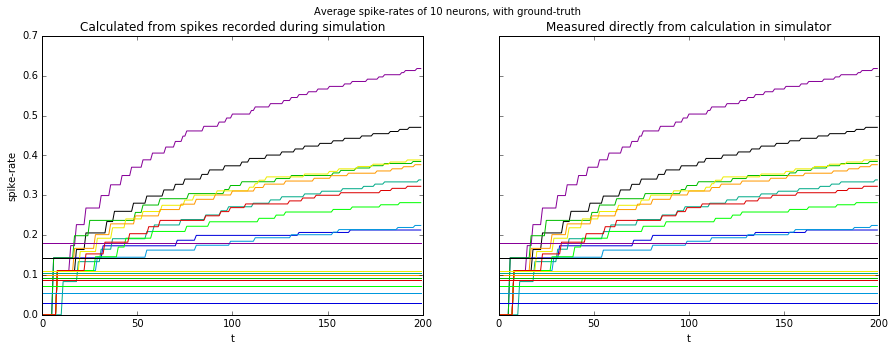

In [12]:
plot_spikerates(spikerates_fir, spikerates_fir_measured, target_activations)

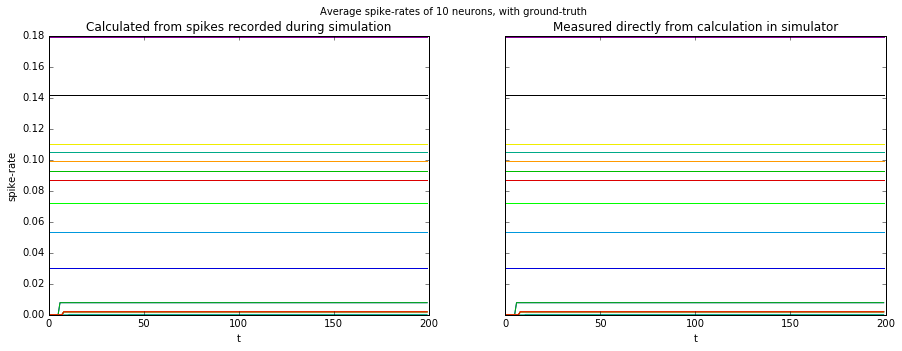

In [16]:
plot_spikerates(spikerates_exp, spikerates_exp_measured, target_activations)

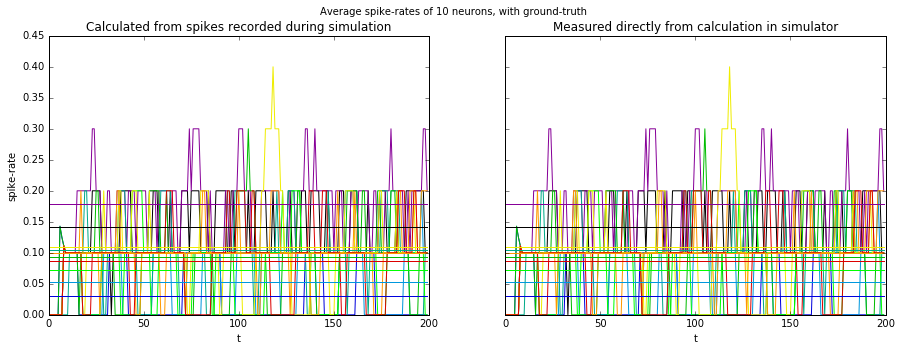

In [36]:
plot_spikerates(spikerates_run, spikerates_run.transpose(), target_activations)

The running average with sliding window does not perform well because the binary updates are large compared to the real-valued average, and cause large jumps. Increasing the window size helps, but only slightly. In the transient phase, for the duration of one window, the running average matches the standard average.

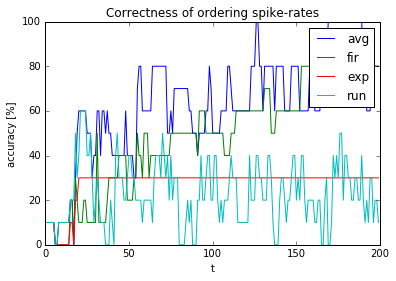

In [12]:
plot_order_correctness([spikerates_avg, spikerates_fir, spikerates_exp, spikerates_run], true_order, ['avg', 'fir', 'exp', 'run'])

What matters for the MaxPool operation is not what value the spike-rates ultimately converge to, but their ordering compared to others in the same patch. This could explain why 'fir' gives the better result, even though it does not converge to the right values. However, for the 10 neurons shown here, 'avg' in fact reaches the correct ordering faster. Note that during the first 60 time steps, all methods have at least 2 units that are wrongly ordered (each contributing 2*10% to the error). One could argue that this is not a big deal, since only the one with highest rate matters.

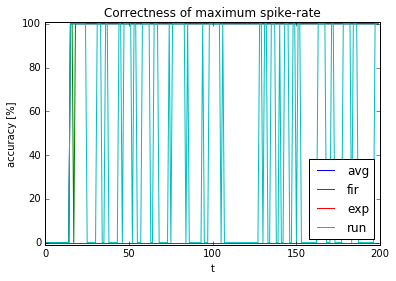

In [20]:
plot_max_correctness([spikerates_avg, spikerates_fir, spikerates_exp, spikerates_run], activations, ['avg', 'fir', 'exp', 'run'])

In this case, 'avg' and 'fir' are equally fast in determining the correct winner. However, it takes about 20 time steps, during which the gating function blocks spikes from the true winner, while the incorrectly chosen winner is not spiking. This should amount to an error of 10%. We observe much more than this.